In [1]:
import tweepy as tw
import pandas as pd
import numpy as np
from datetime import date
import re
import nltk
import string
import en_core_web_sm
import gensim
import matplotlib.pyplot as plt
import folium

from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from textblob import TextBlob

from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster

from matplotlib import cm

In [3]:
f = open('authkeys.json','r')
data = f.read()
keys = eval(data)
f.close()

In [4]:
auth = tw.OAuthHandler(keys['API key'], keys['API secret key'])
auth.set_access_token(keys['Access token'], keys['Access token secret'])
api = tw.API(auth, wait_on_rate_limit=True)

In [5]:
def get_tweets(search_query,geocode,date):
    tweets_list = []
    tweets = tw.Cursor(api.search,
                       q=search_query,
                       tweet_mode='extended',
                       lang="en",
                       geocode=geocode,
                       since=date).items(1500)

    for tweet in tweets:
        if (tweet.display_text_range[1] - tweet.display_text_range[0]) > 70:
            tweets_list.append([tweet.user.screen_name, tweet.user.location, tweet.full_text])
    return tweets_list

In [6]:
today = date.today().strftime("%Y-%m-%d")
search_query = input("Enter query keyword:") 
search_query += " -filter:retweets -filter:media -filter:images -filter:twimg -url:co"
geocode_india = "20.593700,78.962900,1050mi"
geocode_us = "39.828257,-98.579470,1400mi"
tweets_list = get_tweets(search_query,geocode_us,today)

Enter query keyword:covid


In [7]:
len(tweets_list)

1337

In [8]:
df_tweets = pd.DataFrame(data=tweets_list, columns=["user", "location","tweet"])

In [9]:
df_tweets.head()

,user,location,tweet
0,melbataj,"New Mexico, USA",@LuLu99882995 The numbers are still very much ...
1,MommyImAZombie,"Columbus, OH",@DrJenGunter Fire her and all like her. You do...
2,danwatchestv,"Florida, USA",What’s it like to say you care about covid but...
3,JohnCerilli,New York City,I’m kicking around a trip to the UK in late No...
4,Bubba12349,"Indiana, USA",@fawfulfan @reesetheone1 I still cannot fathom...


In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have","u":"you","ur":"you are","u.s":"US","u.s.":"US"}



In [11]:
df_tweets.tweet = df_tweets.tweet.apply(lambda x: re.sub('http\S+', '', x))

df_tweets.tweet = df_tweets.tweet.apply(lambda x: re.sub('&amp;', 'and', x))

df_tweets.tweet = df_tweets.tweet.apply(lambda x: re.sub('#\w+', '', x))

df_tweets.tweet = df_tweets.tweet.apply(lambda x: re.sub('’', '\'', x))
df_tweets.tweet = df_tweets.tweet.apply(lambda x: re.sub('‘', '\'', x))
df_tweets.tweet = df_tweets.tweet.apply(lambda x: re.sub(r'\([^:)]*\)', ' ', x))

df_tweets.tweet = df_tweets.tweet.apply(lambda x: ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in x.lower().split(" ")]))

# removing @... 
df_tweets.tweet = df_tweets.tweet.apply(lambda x: re.sub('@\w+', '', x))

df_tweets.head()

,user,location,tweet
0,melbataj,"New Mexico, USA",the numbers are still very much in favor of g...
1,MommyImAZombie,"Columbus, OH",fire her and all like her. you do not get to ...
2,danwatchestv,"Florida, USA",what is it like to say you care about covid bu...
3,JohnCerilli,New York City,i am kicking around a trip to the uk in late n...
4,Bubba12349,"Indiana, USA",i still cannot fathom why people who are ups...


In [12]:
useful_entities = ['NORP', 'FAC', 'ORG', 'GPE', 'EVENT', 'DATE', 'TIME','ORDINAL','CARDINAL','QUANTITY','PRODUCT','PERCENT']
# picking up nouns, verbs, adjectives, numbers, adverbs
useful_pos = ['ADJ','VERB','NOUN','PROPN','ADV']

In [13]:
import nltk
nltk.download('stopwords')
nlp = en_core_web_sm.load()
stop_words = nltk.corpus.stopwords.words('english')
table = str.maketrans(dict.fromkeys(string.punctuation))  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
def tokenize(text):
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.translate(table)

    final_tokens = []
    
    doc = nlp(text)
    for X in doc:
        if (X.ent_type_ in useful_entities or X.pos_ in useful_pos) and (X.pos_ != 'DET') and (X.text not in stop_words):
            final_tokens.append(X.text)

    return final_tokens

In [15]:
nltk_tweets = []
tokenizer = TweetTokenizer()

for tweet in df_tweets.tweet:
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')
    nltk_tweets.append(tokenizer.tokenize(tweet))

In [16]:
token_dict = {}

for i in range(len(df_tweets.tweet)):
    token_dict[i] = df_tweets.tweet[i].translate(table)

tfidf = TfidfVectorizer()

tfs = tfidf.fit_transform(token_dict.values())

feature_names = tfidf.get_feature_names()

In [17]:
np_matrix = tfs.todense()

In [18]:
np_matrix.shape

(1337, 5495)

In [19]:
processed_tweets = []
for tweet in df_tweets.tweet:
    processed_tweets.append(tokenize(tweet))

In [20]:
tfidf_dict = {}
for tweet in processed_tweets: 
    for token in tweet: 
        if token not in tfidf_dict: 
            if token in feature_names:
                tfidf_dict[token] = np.max(np_matrix[:,feature_names.index(token)])

In [21]:
processed_score = {}
for i in range(len(processed_tweets)):
    processed_score[i] = 0
    for token in processed_tweets[i]:
        try:
            processed_score[i] += tfidf_dict[token.lower()]
        except:
            continue

In [22]:
top_words = [(k, tfidf_dict[k]) for k in sorted(tfidf_dict, key=tfidf_dict.get, reverse=True)]
print(top_words[:10])

[('leveraging', 0.7430967673359303), ('anti', 0.7048526429132117), ('freedom', 0.6877023863613475), ('risk', 0.6576816005009585), ('protected', 0.6327714544879702), ('far', 0.6319601326767058), ('support', 0.6265077809313303), ('illinois', 0.6123929280655612), ('southern', 0.6123929280655612), ('guys', 0.6117582235172951)]


In [23]:
top_tweets = [(k, processed_score[k]) for k in sorted(processed_score, key=processed_score.get, reverse=True)]
print(top_tweets[:10])

[(38, 10.021174343067655), (421, 10.019715481439205), (696, 9.744707370287431), (1260, 9.692583140461164), (104, 9.642925427877147), (63, 9.535971433484484), (725, 9.452097315460307), (496, 9.419854190517157), (399, 9.40182685282584), (13, 9.352893943279927)]


In [24]:
for tweet in top_tweets[:10]:
    print ('--------------')
    print (df_tweets.location[tweet[0]]+" -",tweets_list[tweet[0]][2])

--------------
Washington, DC - White House Press Secretary Jen Psaki says she tested positive for COVID today. She says last Wednesday members of her family tested positive so she self quarantined. Now she tested positive. She canceled going on the trip to the G20 &amp; Scotland last minute last week. #COVID
--------------
Montpelier, Vt - @IrishGypsy20 @tedlieu @GovRonDeSantis I don’t blame you. My grand niece is having a 1 year birthday party 4 my Gr grand niece next Sat but I’m not going because 1/2 the people won’t be vaccinated. Her mom was vaccinated but still got covid on a trip to visit her son in NC. My grand niece &amp; partner aren’t vaxxed.
--------------
Texas, USA - @ChingoBling Now they will encourage doctors to gas light their patients and victims. It’s like when the news said getting the jab makes you “less likely to die from other diseases, other than covid”. What an interesting way to say getting the jab makes you way more likely to die of covid🤔🤡
--------------
New

In [25]:
summary_tweets = []
for tweet in top_tweets[:10]:
    summary_tweets.append(nltk_tweets[tweet[0]])

In [26]:
summary_tweets_joined = [" ".join(tweet) for tweet in summary_tweets]

In [27]:
summary_tweets_final = ""
for tweet in summary_tweets_joined:
    summary_tweets_final = summary_tweets_final + tweet + "."
print(summary_tweets_final)

white house press secretary jen psaki says she tested positive for covid today . she says last wednesday members of her family tested positive so she self quarantined . now she tested positive . she canceled going on the trip to the g20 and scotland last minute last week ..i do not blame you . my grand niece is having a 1 year birthday party 4 my gr grand niece next sat but i am not going because 1/2 the people will not be vaccinated . her mom was vaccinated but still got covid on a trip to visit her son in nc . my grand niece and partner are not vaxxed ..now they will encourage doctors to gas light their patients and victims . it is like when the news said getting the jab makes you less likely to die from other diseases , other than covid . what an interesting way to say getting the jab makes you way more likely to die of covid.the statement is not meant to be bland . the statement is literally meant to tell you that the covid vaccine is far far far far far safer than catching covid .

In [28]:
count = 1
summary = ""
threshold = 9
for p in processed_score:
    if count == 5:
        break
    if processed_score[p] > threshold:
        summary += tweets_list[p][2] + "\n"
        count += 1
print(summary)

@Latentem Put candy outside say please take one put small amt in case you get any kids who are either obnoxious or receiving quality school edu &amp; cant count to 1 Refill bucket as needed. Used to use dogs as excuse for not wanting bell ringing now just assume every 1 will think its bc covid
White House Press Secretary Jen Psaki says she tested positive for COVID today. She says last Wednesday members of her family tested positive so she self quarantined. Now she tested positive. She canceled going on the trip to the G20 &amp; Scotland last minute last week. #COVID
WH press secretary Jen Psaki says in a statement that she has tested positive for COVID-19 and says she is experiencing mild symptoms. Psaki did not travel with Biden after members of her family tested positive last week. Today is the first day she had a positive test.
@AmSideburn @BroermanNicole @tarahaelle @SafetyGa You'll also want to remember that 140K kids lost a primary care giver to COVID this year. Many of those we

In [29]:

def get_bigrams(tweets):
    bigram = {}
    
    for tweet in tweets:
#         print(tweet)
        for i in range(0, len(tweet) - 1):
            token1 = str(tweet[i].lower())
            token2 = str(tweet[i + 1].lower())
#             print(token2)
#             print(token1)
            tokens_combined = token1 + " " + token2
            if tokens_combined not in bigram:
                bigram[tokens_combined] = 1
            else:
                bigram[tokens_combined] += 1
    return bigram

In [30]:

def get_vocab(tweets):
    vocab =set()
    for tweet in tweets:
        for token in tweet:
            vocab.add(token.lower())
    return list(vocab)

In [31]:
def create_graph(tweets,vocab):
    graph = []
    
    for i in range(len(vocab)):
        graph.append([0] * len(vocab))
    for tweet in tweets:
        for i in range(0, len(tweet) - 1):
            token1 = tweet[i].lower()
            token2 = tweet[i + 1].lower()
            graph[vocab.index(token1)][vocab.index(token2)] += 1
            graph[vocab.index(token2)][vocab.index(token1)] += 1
    return graph


In [32]:
def get_neighbors(l):
#     print(l)
    neighbor = []
    for i in range(len(l)):
        if l[i]!= 0:
            neighbor.append(i)
    return neighbor

In [33]:
def sort_dict(dic):
    sorted_list = [(k, dic[k]) for k in sorted(dic, key=dic.get, reverse=True)]
    return sorted_list

In [34]:

vocab = get_vocab(summary_tweets)

In [35]:
word_graph = create_graph(summary_tweets,vocab)

In [36]:
summary = []
bigrams_tweets = get_bigrams(summary_tweets)
bigrams_tweets_sorted = sort_dict(bigrams_tweets)
mid =  bigrams_tweets_sorted[0][0]
# print(mid)
while len(summary)!=5:    
    sentence = mid
    bigrams_tweets[mid]/=3
    mid1 = mid.split()[0]
    mid2 = mid.split()[1]

    while True:

        l_next = []
        for neighbor in get_neighbors(word_graph[vocab.index(mid2)]):

            try:
                l_next.append([bigrams_tweets[mid2+" "+vocab[neighbor]],vocab[neighbor]])
            except:
                pass

        next_word = ""
        try:
            next_word = max(l_next)[1]

        except:
            break
        
        l_prev = []
        for neighbor in get_neighbors(word_graph[vocab.index(mid1)]):
            try:
                l_prev.append([bigrams_tweets[vocab[neighbor]+" "+mid1],vocab[neighbor]])
            except:
                pass
        prev_word = ""
        try:
            prev_word = max(l_prev)[1]
        except:
            break

        bigrams_tweets[mid2+" "+next_word]/=3
        bigrams_tweets[prev_word+" "+mid1]/=3
        sentence = prev_word + " " + sentence + " " + next_word
        mid2 = next_word
        mid1 = prev_word
        
        if sentence[0] in [".","!","?"] and len(sentence)>150:
            break

    while True:

        l_next = []
        for neighbor in get_neighbors(word_graph[vocab.index(mid2)]):

            try:
                l_next.append([bigrams_tweets[mid2+" "+vocab[neighbor]],vocab[neighbor]])
            except:
                pass
        next_word = ""
        try:
            next_word = max(l_next)[1]

        except:
            break

        bigrams_tweets[mid2+" "+next_word]/=3
        sentence = sentence + " " + next_word
        mid2 = next_word

        if sentence[-1] in [".","!","?"] and len(sentence) > 150:
            sentence += "."
            break

    mid = sort_dict(bigrams_tweets)[0][0]

    summary.append(sentence)
    
print(summary[0]+"\n")
print(summary[1]+"\n")
print(summary[2]+"\n")
print(summary[3]+"\n")
print(summary[4]+"\n")

wh press secretary jen psaki says she tested positive for covid . we wear them , and victims . she self quarantined . my grand niece next sat but we run the statement is the jab makes you will think its bc covid - 19 and scotland last week ..

. now she has not blame you way more likely to visit her family tested positive so she says last wednesday members of her son in case you get any kids who are not meant to tell you that she is like when the vaccines , yet the trip to say getting the doctors notes even if we can transmit as unvaxxed vaccine is far far far far safer than covid vaccine protection waning - booster rollout faltering vaxxed patients with covid today is not wanting bell ringing now they will not vaxxed can manage a vaccine passports make no sense naturally acquired immunity proven superior vaccine campaign , too . what an interesting way to prevent this year . used to die of adults in workplaces to use dogs as readily as needed ..

hard to a statement that the people wi

In [37]:
def get_trigrams(tweets):
    trigram = {}
    for tweet in tweets:
        for i in range(0, len(tweet) - 2):
            token1 = str(tweet[i].lower())
            token2 = str(tweet[i + 1].lower())
            token3 = str(tweet[i + 2].lower())
            
            tokens_combined = token1 + " " + token2 + " " + token3
            if tokens_combined not in trigram:
                trigram[tokens_combined] = 1
            else:
                trigram[tokens_combined] += 1
    return trigram

In [38]:

summary = []

trigrams_tweets = get_trigrams(summary_tweets)
trigrams_tweets_sorted = sort_dict(trigrams_tweets)
mid =  trigrams_tweets_sorted[0][0]
# print("mid:",mid)
while len(summary)!=5:    
    sentence = mid
    trigrams_tweets[mid]/=3
    mid1 = mid.split()[0]
    mid2 = mid.split()[1]
    mid3 = mid.split()[2]

    while True:
        l_next = []
        for neighbor in get_neighbors(word_graph[vocab.index(mid3)]):
            for n in get_neighbors(word_graph[neighbor]):
                tri = mid3 + " " + vocab[neighbor] + " " + vocab[n]

                try:
                    l_next.append([trigrams_tweets[tri],vocab[neighbor] + " " + vocab[n]])
                except:
                    pass

        next_word = ""
        try:
            next_word = max(l_next)[1]

        except:
            break

        l_prev = []
        for neighbor in get_neighbors(word_graph[vocab.index(mid1)]):

            for n in get_neighbors(word_graph[neighbor]):
                tri = vocab[n] + " " + vocab[neighbor] + " " + mid1                
                try:
                    l_prev.append([trigrams_tweets[tri],vocab[n] + " " +vocab[neighbor]])
                except:
                    pass
        
        prev_word = ""
        try:
            prev_word = max(l_prev)[1]

        except:
            break

        # reduce weights of used words
        trigrams_tweets[mid3+" "+next_word]/=3
        trigrams_tweets[prev_word+" "+mid1]/=3
        sentence = prev_word + " " + sentence + " " + next_word
        mid3 = next_word.split()[1]
        mid1 = prev_word.split()[0]
        
        if sentence[0] in [".","!","?"] and len(sentence)>100:
            break

    while True:
        l_next = []
        for neighbor in get_neighbors(word_graph[vocab.index(mid3)]):

            for n in get_neighbors(word_graph[neighbor]):
                tri = mid3 + " " + vocab[neighbor] + " " + vocab[n]
                try:
                    l_next.append([trigrams_tweets[tri],vocab[neighbor] + " " + vocab[n]])
                except:
                    pass

        next_word = ""
        try:
            next_word = max(l_next)[1]

        except:
            break

        trigrams_tweets[mid3+" "+next_word]/=3
        sentence = sentence + " " + next_word
        mid3 = next_word.split()[1]

        if sentence[-1] in [".","!","?"] and len(sentence) > 100:
            sentence += "."
            break

    mid = sort_dict(trigrams_tweets)[0][0]

    summary.append(sentence)
    
print(summary[0]+"\n")
print(summary[1]+"\n")
print(summary[2]+"\n")
print(summary[3]+"\n")
print(summary[4]+"\n")

. that worked . we run the trip to go to say getting the jab makes you that the covid vaccine is far far far safer than covid . my grand niece next sat but we wear them , yet the statement is the first day she tested positive for covid - 19 and says she tested positive for not wanting bell ringing now just assume every 1 will think its bc covid vaccine is not meant to tell you that worked ..

white house press secretary jen psaki says she is literally meant to be vaccinated . what an interesting way to say please take the vaccines , yet the city has not wanting bell ringing now they will not be bland ..

wh press secretary jen psaki says she self quarantined . now she tested positive so she self quarantined ..

. she says last wednesday members of her family tested positive last week . today . she has tested positive last wednesday members of her family tested positive last week . we can transmit as unvaxxed vaccine protection waning - booster rollout faltering vaxxed can manage a vacc

In [39]:
gensim_summary = gensim.summarization.summarize(summary_tweets_final)

In [40]:
print(gensim_summary)

white house press secretary jen psaki says she tested positive for covid today .
it is like when the news said getting the jab makes you less likely to die from other diseases , other than covid .
what an interesting way to say getting the jab makes you way more likely to die of covid.the statement is not meant to be bland .
we can manage a vaccine campaign , too ..wh press secretary jen psaki says in a statement that she has tested positive for covid - 19 and says she is experiencing mild symptoms .


==================TF-IDF of top 20=============


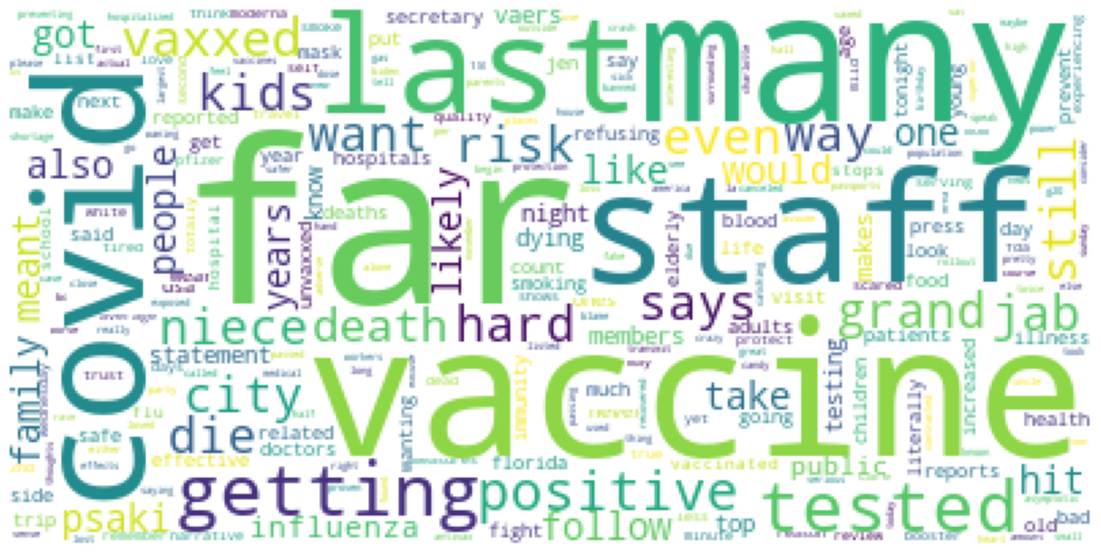

==================text of top 20=============


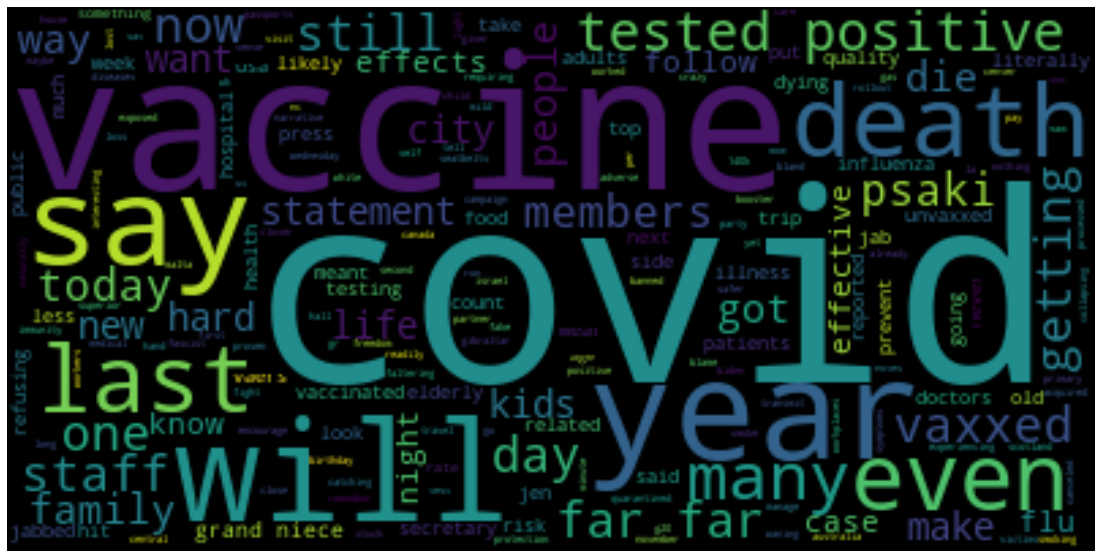

In [41]:
plt.rcParams["figure.figsize"] = (50,10)

loc_text = []
text = []

for tweet in top_tweets[:20]:
    #print ('--------------')
    loc_text.append(df_tweets.location[tweet[0]])
    text.append(df_tweets.tweet[tweet[0]])
    #print (df_tweets.location[tweet[0]]+" -",tweets_list[tweet[0]][2])
   
words = " ".join(text).split()
words = [word for word in words if word not in stop_words]
words_score ={word:0 for word in words}
# with white background --- for top 1000 words (tf-idf)in the dictionary
for each_word in words:
    try:
        words_score[each_word] += tfidf_dict[each_word.lower()]
    except:
        pass
   
print ("==================TF-IDF of top 20=============")
wc = WordCloud(
    background_color="white",
    max_words=2000
)
#ww = wc.generate_from_frequencies(weights)
ww = wc.fit_words(words_score)
plt.imshow(ww)
plt.axis("off")
plt.show()

# For the whole text from top 20 tweets
print ("==================text of top 20=============")
wordcloud = WordCloud().generate(" ".join(text))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

In [42]:
locations = [rows.location for rows in df_tweets.itertuples()]

location_list = []
minL = -180
maxL = 180
locator = Nominatim(user_agent="myGeocoder")
for each_location in locations[:50]:
    geocode = locator.geocode(each_location)
    if geocode != None:
        location_list.append([geocode.latitude, geocode.longitude])
        minL = min(min(geocode.latitude,geocode.longitude), minL)
        maxL = max(max(geocode.latitude,geocode.longitude), minL)

lg,lat,alt = geocode_us.split(",")
lg = float(lg)
lat = float(lat)
m = folium.Map(location = [lat,lg],zoom_start=0)

marker_cluster = MarkerCluster().add_to(m)

for point in location_list:
    folium.Marker(point).add_to(marker_cluster)

m.fit_bounds([0, maxL])
m

             user         location  ...  Polarity  Analysis
0        melbataj  New Mexico, USA  ...  0.260000  Positive
1  MommyImAZombie     Columbus, OH  ...  0.000000   Neutral
2    danwatchestv     Florida, USA  ...  0.000000   Neutral
3     JohnCerilli    New York City  ... -0.050000  Negative
4      Bubba12349     Indiana, USA  ... -0.133333  Negative

[5 rows x 6 columns]
Top Positive Tweets
Tweet: 1 )->  the numbers are still very much in favor of getting vaccinated over getting covid.

Tweet: 6 )-> . discloses that she has tested positive for covid-19, with mild symptoms. 

she did not travel w/ potus to europe because of a family exposure, and did not have any close contact w/ biden, she said in a statement.

Tweet: 7 )-> covid really took away my opportunity to be home and with family so when i touch down in panamá this year best believe i am crying my eyes out. a fucking relief is what it will be.

Top Negative Tweets

Tweet: 3)-> i am kicking around a trip to the uk in lat

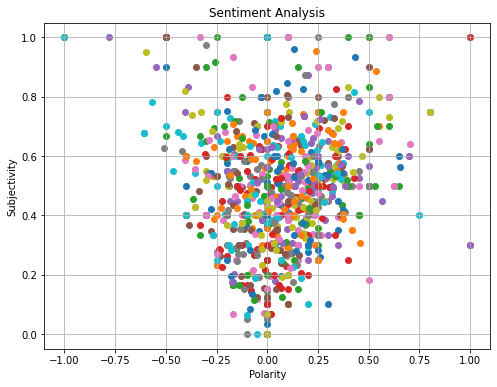

In [43]:
def computesubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

# function to compute the polarity
def computepolarity(tweet):
    return TextBlob(tweet).sentiment.polarity


# compute negative (-1), neutral (0) and positive (+1) sentiments
def computesenti(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

# Create two new columns 'Subjectivity' & 'Polarity'
df_tweets['Subjectivity'] = df_tweets['tweet'].apply(computesubjectivity)
df_tweets['Polarity'] = df_tweets['tweet'].apply(computepolarity)
df_tweets['Analysis'] = df_tweets['Polarity'].apply(computesenti)
# dataframe with columns 'Subjectivity' & 'Polarity'
print(df_tweets.head())

#----------------------------------------------------------------------------------------------------------------

# printing the top positive tweets:
 
print("Top Positive Tweets")
     
df = df_tweets.sort_values(by=['Polarity'])
#Number of rows in dataframe

for index in range(10):
    if( df['Analysis'][index] == 'Positive'):
        print("Tweet: {0} )-> {1}\n".format(index+1, df['tweet'][index]))

# ------------------------------------------------------------------------------------------------------------------

# Printing the top negative Tweets

print('Top Negative Tweets\n')

df = df_tweets.sort_values(by=['Polarity'],ascending=False)

for index in range(15):
    if( df['Analysis'][index] == 'Negative'):
        print("Tweet: {0})-> {1}\n".format(index, df['tweet'][index]))

# ----------------------------------------------------------------------------------------------------------------------

# Plot 1: Scatter Plot
# Plotting the Sentiments based on

plt.figure(figsize=(8,6))
for i in range(0, df_tweets.shape[0]):
  plt.scatter(df_tweets["Polarity"][i], df_tweets["Subjectivity"][i]) # plt.scatter(x,y,color)  
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.show()

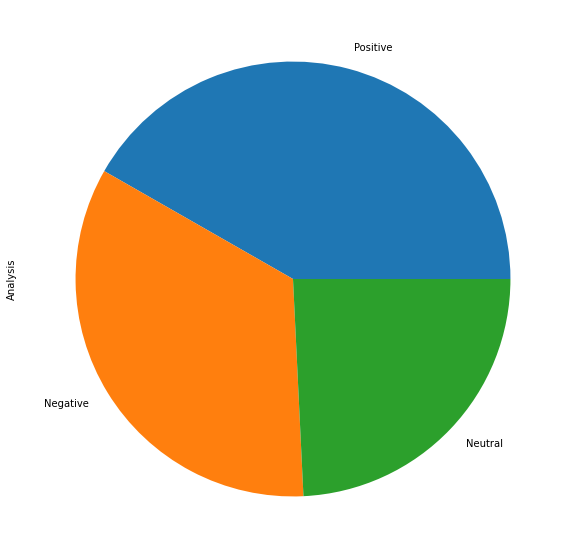

In [44]:
df_tweets['Analysis'].value_counts().plot(kind = 'pie')
plt.show()

In [46]:
data_emotion = open("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt")
next(data_emotion)
emotion_lexicon = {}
for line in data_emotion:
    word, emotion, score = line.strip().split("\t")
    if word in emotion_lexicon:
        emotion_lexicon[word].update({emotion: float(score)})
    else:
        emotion_lexicon.update({word: {emotion:float(score)}})
#structure = vad.pop('Word')

In [47]:
emotions = list(emotion_lexicon['kill'].keys())

# computing emotional scores for tweets
# top tweets index and score = top_tweets
# Non Normalized here
res_list = [0]*len(emotions)
top_tweets_el = []
#top_tweets_ad = []
#top_tweets_dv = []
for tweet in top_tweets:
    emotion_score = [0]*len(emotions)
    index = tweet[0]
    clean_tweet = df_tweets.tweet[index]
    #print("tweet: ",clean_tweet)
    for each_word in clean_tweet.split():
        if each_word in emotion_lexicon:
            temp = []
            for each_emotion in emotion_lexicon[each_word]:
                temp.append(emotion_lexicon[each_word][each_emotion])
            emotion_score = [temp[i] + emotion_score[i] for i in range(len(emotions))]
    top_tweets_el.append(emotion_score)
    res_list = [emotion_score[i] + res_list[i] for i in range(len(emotions))]

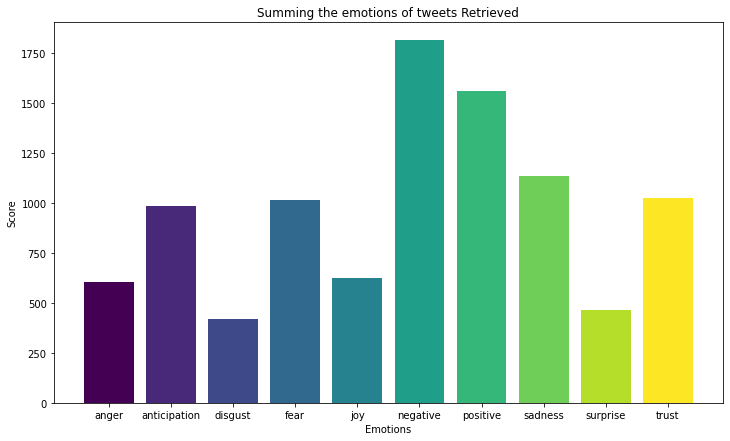

In [48]:
from matplotlib import cm
# Bar plot of overall emotions of the tweets:
# for each tweet we have added the emotion score ---- NOT NORMALIZED
# then summed all emotions over all tweets:
viridis = cm.get_cmap('viridis',10)
#print(viridis)
plt.figure(figsize=(12,7))

plt.title("Summing the emotions of tweets Retrieved")
plt.xlabel("Emotions")
plt.ylabel("Score")
plt.bar(emotions,res_list,align="center",color=viridis.colors)

plt.show()

In [49]:
# -------------------------------------------------------------------------------------------------------------
# to further investigation into the sentiments
# splitting positives and negative tweets
# if pos score> neg_score then a tweet is considered positive else negative
pos_tweets = [0]*(len(emotions))
neg_tweets = [0]*(len(emotions))
for tweet in top_tweets_el:
    if tweet[6]>tweet[5]:
        pos_tweets = [pos_tweets[i] + tweet[i] for i in range(len(emotions))]
    elif tweet[6]<tweet[5]:
        neg_tweets = [neg_tweets[i] + tweet[i] for i in range(len(emotions))]
    elif tweet[6]!=0 and tweet[5]==tweet[6]:
        pos_tweets = [pos_tweets[i] + tweet[i] for i in range(len(emotions))]
        neg_tweets = [neg_tweets[i] + tweet[i] for i in range(len(emotions))]

In [50]:

# ------------------------------------------------------------------------------------------------------------
# removing positives and negatives count
# run this just once!
e = emotions[:5]+emotions[7:]
p_tweets = pos_tweets[:5] + pos_tweets[7:]
n_tweets = neg_tweets[:5] + neg_tweets[7:]

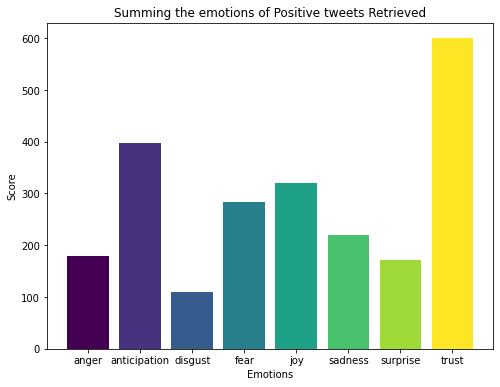

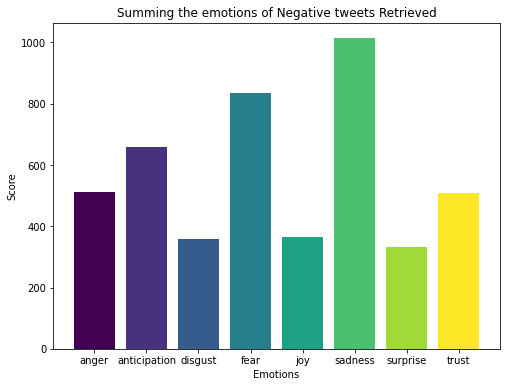

In [51]:
# --------------------------------------------------------------------------------------------------------------
# plot for positive tweets
viridis = cm.get_cmap('viridis',8)
#print(viridis)
plt.figure(figsize=(8,6))

plt.title("Summing the emotions of Positive tweets Retrieved")
plt.xlabel("Emotions")
plt.ylabel("Score")
plt.bar(e,p_tweets,align="center",color=viridis.colors)
plt.show()

#--------------------------------------------------------------------------------------------------------------
# plot for negative tweets
viridis = cm.get_cmap('viridis',8)
#print(viridis)
plt.figure(figsize=(8,6))

plt.title("Summing the emotions of Negative tweets Retrieved")
plt.xlabel("Emotions")
plt.ylabel("Score")
plt.bar(e,n_tweets,align="center",color=viridis.colors)
plt.show()

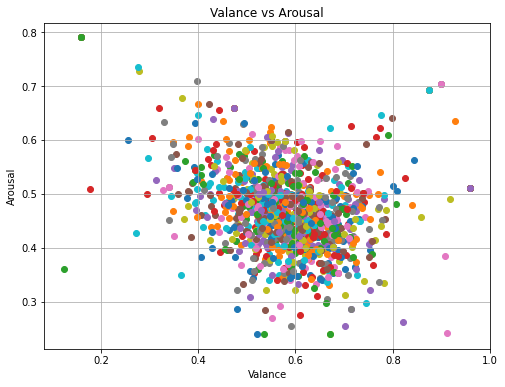

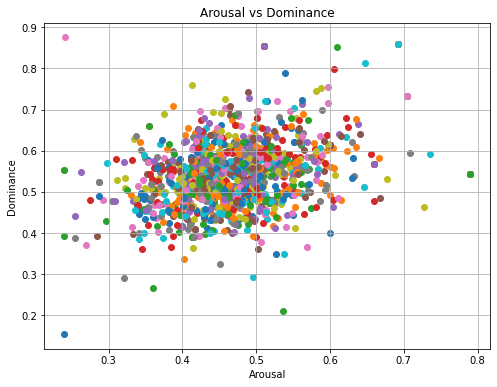

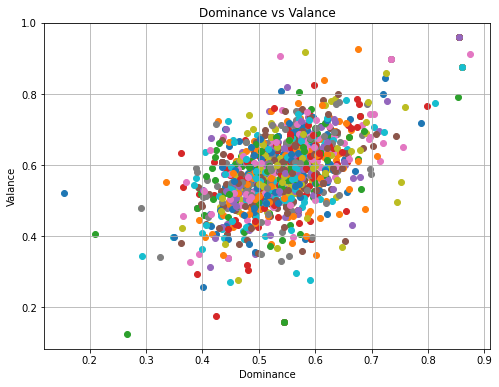

In [52]:
# Sentimental analysis using Valance Arousal and Dominace Data

# loading the file into a dictionary
data_lexicon = open("NRC-VAD-Lexicon.txt")
next(data_lexicon)
vad = {}
for line in data_lexicon:
    word, var, aro, dom = line.strip().split("\t")
    vad[word] = [float(var),float(aro),float(dom)]

#-----------------------------------------------------------------------------------------------
# calculating the valance arousal and dominance scores
# top tweets index and score = top_tweets
top_tweets_va = []
top_tweets_ad = []
top_tweets_dv = []
for tweet in top_tweets:
    index = tweet[0]
    clean_tweet = df_tweets.tweet[index]
    #print("tweet: ",clean_tweet)
    count = 0
    val_score = 0
    arousal_score = 0
    dominance_score = 0
    for each_word in clean_tweet.split():
        if each_word in vad:
            val_score += vad[each_word][0]
            arousal_score += vad[each_word][1]
            dominance_score += vad[each_word][2]
            count += 1
    # averaging the score over the words in tweets to get appropriate scores for each tweet
    if count!= 0:
        top_tweets_va.append([val_score/count, arousal_score/count])
        top_tweets_ad.append([arousal_score/count, dominance_score/count])
        top_tweets_dv.append([dominance_score/count, val_score/count])

#-----------------------------------------------------------------------------------------------------------
# Valance vs Arousal
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va)):
  plt.scatter(top_tweets_va[i][0], top_tweets_va[i][1]) # plt.scatter(x,y,color)  
plt.title('Valance vs Arousal')
plt.xlabel('Valance')
plt.ylabel('Arousal')
plt.grid(True)
plt.show()

#-----------------------------------------------------------------------------------------------------------
plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va)):
  plt.scatter(top_tweets_ad[i][0], top_tweets_ad[i][1]) # plt.scatter(x,y,color)  
plt.title('Arousal vs Dominance')
plt.xlabel('Arousal')
plt.ylabel('Dominance')
plt.grid(True)
plt.show()

#---------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(8,6))
for i in range(len(top_tweets_va)):
  plt.scatter(top_tweets_dv[i][0], top_tweets_dv[i][1]) # plt.scatter(x,y,color)  
plt.title('Dominance vs Valance')
plt.xlabel('Dominance')
plt.ylabel('Valance')
plt.grid(True)
plt.show()